In [1]:
## train a classification model to classify the stance of the golf player by estimating the pose

In [38]:
import cv2
import numpy as np
from ultralytics import YOLO
import os
import pandas as pd
import seaborn as sns 
import random
import pickle

In [2]:
import argparse
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from eval import ToTensor, Normalize
from model import EventDetector
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


In [4]:
from dataloader import GolfDB, Normalize, ToTensor

In [5]:
from scipy.io import loadmat
x = loadmat('data/golfDB.mat')
l = list(x['golfDB'][0])

In [6]:
def load_df(file_name):
    from scipy.io import loadmat
    import pandas as pd
    pd.options.display.width = None
    pd.set_option("max_colwidth", None)
    pd.options.display.max_rows = 999

    x = loadmat(file_name)
    l = list(x['golfDB'][0])
    d = dict()
    for idx, k in enumerate(l):
        d["{:3d}".format(idx)] = list(l[idx])
    df = pd.DataFrame(d).T
    df.columns = ["id", "youtube_id", "player", "sex", "club", "view", "slow", "events", "bbox", "split"]
    # 10 events = start_frame(SF), address(A), Toe-up(TU), Mid-backswing(MB), Top(T), Mid-downswing(MD), Impact(I),
    # Mid-follow-through(MFT), Finsh(F), end_frame(EF)
    # data format cleansing
    df['id'] = df['id'].apply(lambda x: x[0][0])
    df['youtube_id'] = df['youtube_id'].apply(lambda x: x[0])
    df['player'] = df['player'].apply(lambda x: x[0])
    df['sex'] = df['sex'].apply(lambda x: x[0])
    df['club'] = df['club'].apply(lambda x: x[0])
    df['view'] = df['view'].apply(lambda x: x[0])
    df['slow'] = df['slow'].apply(lambda x: x[0][0])
    df['events'] = df['events'].apply(lambda x: x[0])
    df['bbox'] = df['bbox'].apply(lambda x: x[0])
    df['split'] = df['split'].apply(lambda x: x[0][0])
    df = df.drop(columns=['split', 'youtube_id'])

    df.index = df.index.astype(int)
    df.to_csv('golfDB.csv')

    print("Number of annotations: {:3d}".format(len(df.id)))
    return df

In [7]:
## read metadata
df = load_df('data/golfDB.mat')


Number of annotations: 1400


In [8]:
df.head()

,id,player,sex,club,view,slow,events,bbox
0,0,SANDRA GAL,f,driver,down-the-line,0,"[408, 455, 473, 476, 490, 495, 498, 501, 514, 545]","[0.09765625000000001, 0.006944444444444444, 0.50234375, 0.9805555555555555]"
1,1,SANDRA GAL,f,driver,down-the-line,1,"[814, 854, 917, 931, 988, 1006, 1019, 1030, 1083, 1137]","[0.039062500000000014, 0.0006944444444444445, 0.6125, 0.9784722222222222]"
2,2,CHRIS DIMARCO,m,driver,down-the-line,0,"[521, 659, 678, 683, 692, 696, 698, 701, 715, 745]","[0.165625, 0.0006944444444444445, 0.48359375, 0.9868055555555556]"
3,3,CHRIS DIMARCO,m,driver,down-the-line,1,"[1106, 1190, 1244, 1264, 1300, 1313, 1324, 1335, 1389, 1449]","[0.18515625, 0.0006944444444444445, 0.465625, 0.9715277777777778]"
4,4,BROOKE HENDERSON,f,driver,down-the-line,0,"[157, 170, 183, 188, 197, 201, 205, 207, 220, 250]","[0.11015625, 0.0006944444444444445, 0.4984375, 0.9868055555555556]"


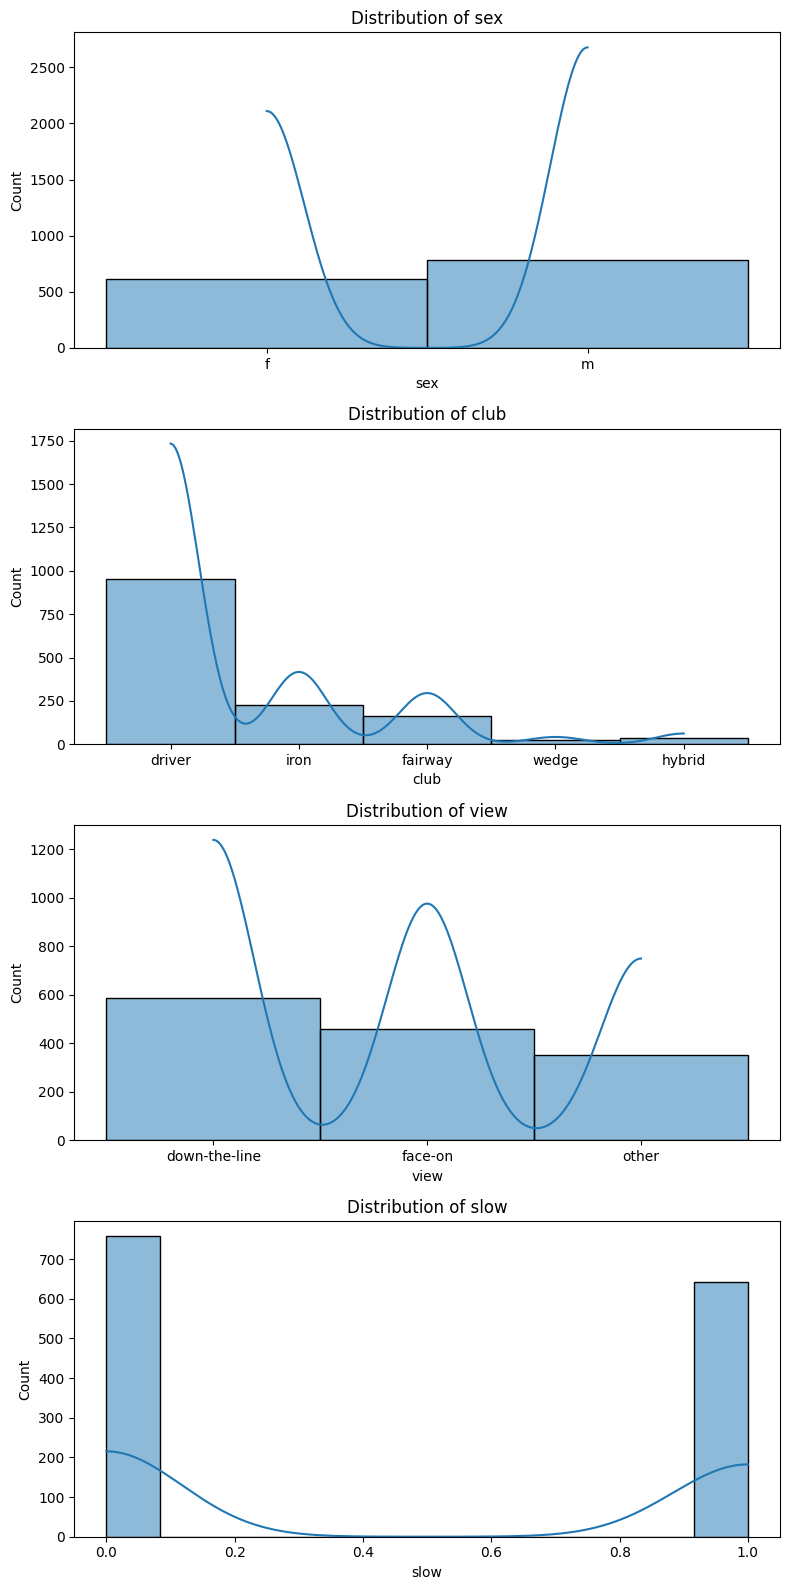

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 4*4))
col_names = ["sex", "club", "view", "slow"]
i =0 
for col in col_names:
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    i = i + 1
plt.tight_layout()
plt.show()



In [10]:
## lets look at some of the 

In [11]:
event_names = {
    0: 'Address',
    1: 'Toe-up',
    2: 'Mid-backswing (arm parallel)',
    3: 'Top',
    4: 'Mid-downswing (arm parallel)',
    5: 'Impact',
    6: 'Mid-follow-through (shaft parallel)',
    7: 'Finish'
}

In [12]:

## lets look at the three view types, face-on and down-the-line and others
examples_face_on = random.choice(list(df[df.view=="face-on"].id))
examples_down_the_line = random.choice(list(df[df.view=="down-the-line"].id))
examples_other1 = random.choice(list(df[df.view=="other"].id))
examples_other2 = random.choice(list(df[df.view=="other"].id))
examples_face_on, examples_down_the_line, examples_other1,examples_other2

(1199, 505, 1025, 718)

In [13]:
pose_model = YOLO("yolo11x-pose.pt" )


In [14]:
def save_pose_output( id, type):
    # Open the video file
    input_video_path = "data/videos_160/" + str(id) + ".mp4"
    cap = cv2.VideoCapture(input_video_path)
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    # Define the output video writer
    output_video_path = type + "_" + str(id) + '_output_video.mp4'
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    results = pose_model(input_video_path,stream=True)
    # Process each frame
    for result in results:
        # Get the annotated frame with keypoints
        annotated_frame = result.plot()
    
        # Write the frame to the output video
        out.write(annotated_frame)
    
        # Optionally, display the frame
        #cv2.imshow('Pose Estimation', annotated_frame)
        #if cv2.waitKey(1) & 0xFF == ord('q'):
        #    break
    
    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
save_pose_output(examples_face_on, "face_on")
save_pose_output(examples_down_the_line, "down_the_line")
save_pose_output(examples_other1, "other1")
save_pose_output(examples_other2, "other2")


## So, I think club type and the pose would have effect on the pose estimation. Sex and speed may have more granular effect, but considering only club type and pose type for stance accuracy now

In [15]:
## make subset of the data

In [16]:
class SampleVideo(Dataset):
    def __init__(self, path, input_size=160, transform=None, filter_video_list = []):
        self.path = path
        self.input_size = input_size
        self.transform = transform

        # Get a list of all video files in the folder
        self.video_files = [os.path.join(path, f) for f in os.listdir(path) 
                            if f.endswith(('.mp4'))]
        if len(filter_video_list) > 0:
            filtered_list = [item for item in filter_video_list if item in self.video_files ]
            self.video_files = filtered_list


        # Check if the folder contains videos
        if not self.video_files:
            raise ValueError(f"No video files found in {path}.")

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = self.video_files[idx]
        cap = cv2.VideoCapture(video_path)
        frame_size = [cap.get(cv2.CAP_PROP_FRAME_HEIGHT), cap.get(cv2.CAP_PROP_FRAME_WIDTH)]
        ratio = self.input_size / max(frame_size)
        new_size = tuple([int(x * ratio) for x in frame_size])
        delta_w = self.input_size - new_size[1]
        delta_h = self.input_size - new_size[0]
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)

        # preprocess and return frames
        images = []
        for pos in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            _, img = cap.read()
            resized = cv2.resize(img, (new_size[1], new_size[0]))
            b_img = cv2.copyMakeBorder(resized, top, bottom, left, right, cv2.BORDER_CONSTANT,
                                       value=[0.406 * 255, 0.456 * 255, 0.485 * 255])  # ImageNet means (BGR)

            b_img_rgb = cv2.cvtColor(b_img, cv2.COLOR_BGR2RGB)
            images.append(b_img_rgb)
        cap.release()
        labels = np.zeros(len(images)) # only for compatibility with transforms
        sample = {'images': np.asarray(images), 'labels': np.asarray(labels)}
        if self.transform:
            sample = self.transform(sample)
        return sample , video_path


In [17]:
# Define the folder containing videos
video_folder = "data/videos_160/"

In [18]:
model = EventDetector(pretrain=True,
                    width_mult=1.,
                    lstm_layers=1,
                    lstm_hidden=256,
                    bidirectional=True,
                    dropout=False)
try:
    save_dict = torch.load('models/swingnet_1800.pth.tar')
except:
    print("Model weights not found. Download model weights and place in 'models' folder. See README for instructions")

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model.load_state_dict(save_dict['model_state_dict'])
model.to(device)
model.eval()
print("Loaded model weights")
seq_length = 64

Using device: cuda
Loaded model weights


In [20]:
def detect_events(dl):
    print('Identifying frames for each of the 8 events in the 1400 videos...')
    all_videos_frames =[]
    all_video_confidence = []
    video_paths = []
    ii = 0
    for sample,video_path in dl:
        print("Processing ", ii, ": ",  video_path[0])
        ii = ii + 1
        images = sample['images']
        video_paths.append(video_path[0])
        
        # full samples do not fit into GPU memory so evaluate sample in 'seq_length' batches
        batch = 0
        while batch * seq_length < images.shape[1]:
            if (batch + 1) * seq_length > images.shape[1]:
                image_batch = images[:, batch * seq_length:, :, :, :]
            else:
                image_batch = images[:, batch * seq_length:(batch + 1) * seq_length, :, :, :]
            logits = model(image_batch.cuda())
            if batch == 0:
                probs = F.softmax(logits.data, dim=1).cpu().numpy()
            else:
                probs = np.append(probs, F.softmax(logits.data, dim=1).cpu().numpy(), 0)
            batch += 1
    
        events = np.argmax(probs, axis=0)[:-1]
        #print('Predicted event frames: {}'.format(events))
        cap = cv2.VideoCapture(video_path[0])
        confidence = []
        for i, e in enumerate(events):
            confidence.append(probs[e, i])
        all_video_confidence.append(confidence)
        #print('Condifence: {}'.format([np.round(c, 3) for c in confidence]))
        
        img_list = [] 
        for i, e in enumerate(events):
            cap.set(cv2.CAP_PROP_POS_FRAMES, e)
            _, img = cap.read()
            #cv2.putText(img, '{:.3f}'.format(confidence[i]), (20, 20), cv2.FONT_HERSHEY_DUPLEX, 0.75, (0, 0, 255))
            #plt.imshow(img)
            #plt.show()
            img_list.append(img)
            #cv2.imshow(event_names[i], img)
            #cv2.waitKey(0)
            #cv2.destroyAllWindows()
        all_videos_frames.append(img_list)
    return all_videos_frames

In [21]:
## extract the frames using the precalculations from mat file
def extract_frames(ids, df):
    all_videos_frames = []
    for id in ids:
        video_path = "data/videos_160/" + str(id) + ".mp4"
        print(video_path)
        cap = cv2.VideoCapture(video_path)

        # Check if the video was opened successfully
        if not cap.isOpened():
            print("Error: Could not open video.")
            exit()
        frames = []
        frame_indices = list(df[df.id==id].events)[0]
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Total frames in the video: {total_frames}")

        # Loop through the frame indices and extract frames
        for index in frame_indices:
            
            # Set the video capture to the specific frame
            cap.set(cv2.CAP_PROP_POS_FRAMES, index)
            
            # Read the frame
            ret, frame = cap.read()
            print(ret)
            
            
            # Save or process the frame as needed
            frames.append(frame)
        all_videos_frames.append(frames)

    return all_videos_frames
        
                
        

In [25]:
# Define threshold for minimal head movement
THRESHOLD = 0.1  # Adjust based on your requirements

In [26]:
def calculate_distance(pos1, pos2):
    """Calculate Euclidean distance between two points."""
    return np.linalg.norm(np.array(pos1) - np.array(pos2))

In [27]:
def extract_head_position(pose_keypoints):
    """
    Extract head position from YOLOv11 pose keypoints.
    YOLOv11 pose keypoints format: [x1, y1, x2, y2, ..., x17, y17]
    Head is typically keypoint 0 (nose) or keypoint 1 (left eye).
    """
    if len(pose_keypoints) >= 2:  # Ensure keypoints are available
        return (pose_keypoints[0], pose_keypoints[1])  # Use nose as head position
    return None

In [73]:
def classify_stance(head_positions, bad_threshold_top=0.1 , bad_threshold_impact=0.1):
    """
    Classify stance as "good" or "bad" based on head movement.
    """
    address_pos = head_positions["Address"]
    top_pos = head_positions["Top"]
    impact_pos = head_positions["Impact"]

    distance_top = calculate_distance(address_pos, top_pos)
    distance_impact = calculate_distance(address_pos, impact_pos)
    threshold = min(bad_threshold_top, bad_threshold_impact)
    if distance_top < threshold and distance_impact <threshold:
        return "Good", distance_top, distance_impact
    return "Bad", distance_top, distance_impact

In [49]:
from enum import IntEnum

class GetKeypoint(IntEnum):
    NOSE= 0
    LEFT_EYE = 1
    RIGHT_EYE = 2
    LEFT_EAR = 3
    RIGHT_EAR= 4
    LEFT_SHOULDER = 5
    RIGHT_SHOULDER = 6
    LEFT_ELBOW = 7
    RIGHT_ELBOW = 8
    LEFT_WRIST = 9
    RIGHT_WRIST = 10
    LEFT_HIP = 11
    RIGHT_HIP = 12
    LEFT_KNEE = 13
    RIGHT_KNEE = 14
    LEFT_ANKLE = 15
    RIGHT_ANKLE = 16

In [30]:
## do the pose estimation
# Load a model
pose_model = YOLO("yolo11x-pose.pt" )


In [31]:
def pose_estimation(frames):
     return pose_model(frames)

In [74]:
def calculate_head_movement_metric(results, videos):
    ## lets first do the simple classification based on the head movement, using a threshold of 0.1, and only three events
    # Initialize head positions dictionary
    head_positions_list = []
    i = 0
    res_values = []
    for result in results:
        head_positions = {}
        for event_id in [0,3,5]:
            keypoints = result[event_id].keypoints.xyn.cpu().numpy()[0]
            head_position = extract_head_position(keypoints)
            head_positions[event_names[event_id]] = head_position 
        head_positions_list.append(head_positions)
        res, distance_top, distance_impact = classify_stance(head_positions)
        res_values.append({'video_path': videos[i],  'distance_top' : distance_top, 'distance_impact': distance_impact})

    res_df = pd.DataFrame(res_values)
    # Calculate mean and standard deviation with the assumptions, that the bad stances will be the outliers, given the data if from the pros( so they all should have good stances) 
    mean_top = np.mean(res_df.distance_top)
    std_top = np.std(res_df.distance_top)
    
    mean_impact = np.mean(res_df.distance_impact)
    std_impact = np.std(res_df.distance_impact)
    
    # Define thresholds
    good_threshold_top = mean_top + 1 * std_top
    bad_threshold_top = mean_top + 2 * std_top
    
    good_threshold_impact = mean_impact + 1 * std_impact
    bad_threshold_impact = mean_impact + 2 * std_impact

    
    
    print(f"Good threshold for Distance Top: {good_threshold_top}")
    print(f"Bad threshold for Distance Top: {bad_threshold_top}")
    print(f"Good threshold for Distance Impact: {good_threshold_impact}")
    print(f"Bad threshold for Distance Impact: {bad_threshold_impact}")
    
    res_list = []
    for head_position in head_positions_list:
        res, distance_top, distance_impact = classify_stance(head_position, bad_threshold_top, bad_threshold_impact)
        res_list.append(res)
    res_df["head movement"] = res_list 
    
    return res_df
        

In [70]:
def create_distribution_plot(df):
    # Create a figure with 3 subplots (1 for "head movement" count, 2 for numeric distributions)  
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  
    
    float_cols = ["distance_top", "distance_impact"]
    # 1️⃣ Count plot for "head movement"  
    sns.countplot(x="head movement", data=df, palette={"Good": "green", "Bad": "red"}, ax=axes[0], hue="head movement", legend= False)  
    axes[0].set_title("Distribution of Head Movement Categories")  
    axes[0].set_xlabel("Category")  
    axes[0].set_ylabel("Count")  
    
    # 2️⃣ & 3️⃣ Histograms for floating-point columns with outliers (>3 SD)  
    for i, col in enumerate(float_cols):  
        mean = df[col].mean()  
        std = df[col].std()  
        lower_bound = mean - 2 * std  
        upper_bound = mean + 2 * std  
    
        # Identify outliers beyond ±2 SD  
        outliers = df[(df[col] > upper_bound) | (df[col] < lower_bound)]  
    
        # Plot histogram with KDE  
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i + 1], color="blue")  
        axes[i + 1].axvline(mean, color="black", linestyle="dashed", label="Mean")  
        axes[i + 1].axvline(upper_bound, color="red", linestyle="dashed", label="+2 SD")  
        axes[i + 1].axvline(lower_bound, color="red", linestyle="dashed", label="-2 SD")  
    
        # Annotate outliers  
        if not outliers.empty:  
            axes[i + 1].scatter(outliers[col], np.zeros(len(outliers)), color="red", label="Outliers (>2 SD)")  
    
        axes[i + 1].set_title(f"Distribution of {col}")  
        axes[i + 1].set_xlabel(col)  
        axes[i + 1].set_ylabel("Frequency")  
        axes[i + 1].legend()  
    
    # Show plot  
    plt.tight_layout()  
    plt.show()  



In [ ]:
## Running it for whole images and save it in pickle file for quick reload if session dies
ds = SampleVideo(video_folder, transform=transforms.Compose([ToTensor(),
                                Normalize([0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]))
dl = DataLoader(ds, batch_size=1, shuffle=False, drop_last=False)
all_videos_frames = detect_events(dl)
import pickle
with open('frame_estimate.pkl', 'wb') as handle:
    pickle.dump(all_videos_frames, handle)


In [78]:
frame_pickel = open('frame_estimate.pickle', 'rb')
all_videos_frame = pickle.load(frame_pickel)


In [ ]:
## running the pose estimation of all files and saving it as pickle file for quick reload in case of session dies
pose_results = []
for frames in all_videos_frames:
    pose_results.append(pose_estimation(frames))

with open('pose_results.pkl', 'wb') as handle:
    pickle.dump(all_videos_frames, handle)

In [43]:
pose_pickel = open('pose_results.pkl', 'rb')
all_videos_pose_results = pickle.load(pose_pickel)


processing driver and down-the-line: 423
Good threshold for Distance Top: 0.6732487976551056
Bad threshold for Distance Top: 1.0078316926956177
Good threshold for Distance Impact: 0.4485122412443161
Bad threshold for Distance Impact: 0.7180411964654922


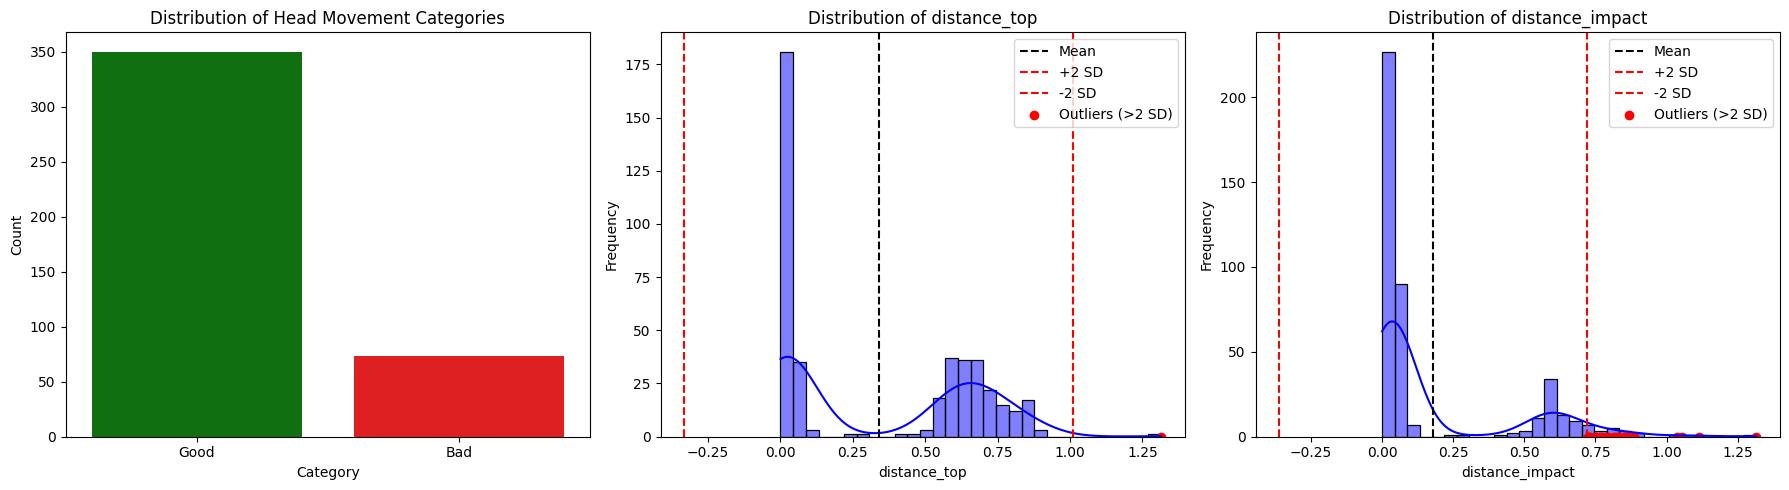

processing driver and face-on: 342
Good threshold for Distance Top: 0.6977092921733856
Bad threshold for Distance Top: 1.0392694175243378
Good threshold for Distance Impact: 0.4314366281032562
Bad threshold for Distance Impact: 0.6892566978931427


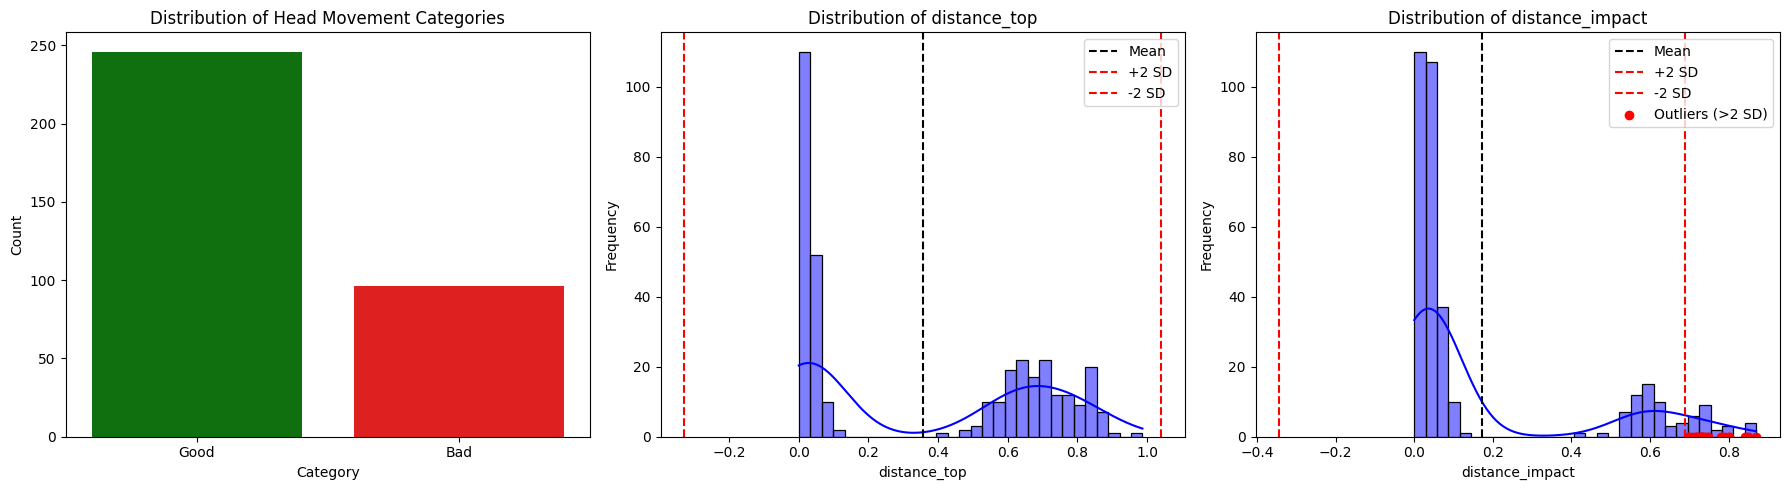

processing driver and other: 187
Good threshold for Distance Top: 0.615867018699646
Bad threshold for Distance Top: 0.9422069787979126
Good threshold for Distance Impact: 0.45902448892593384
Bad threshold for Distance Impact: 0.7375552952289581


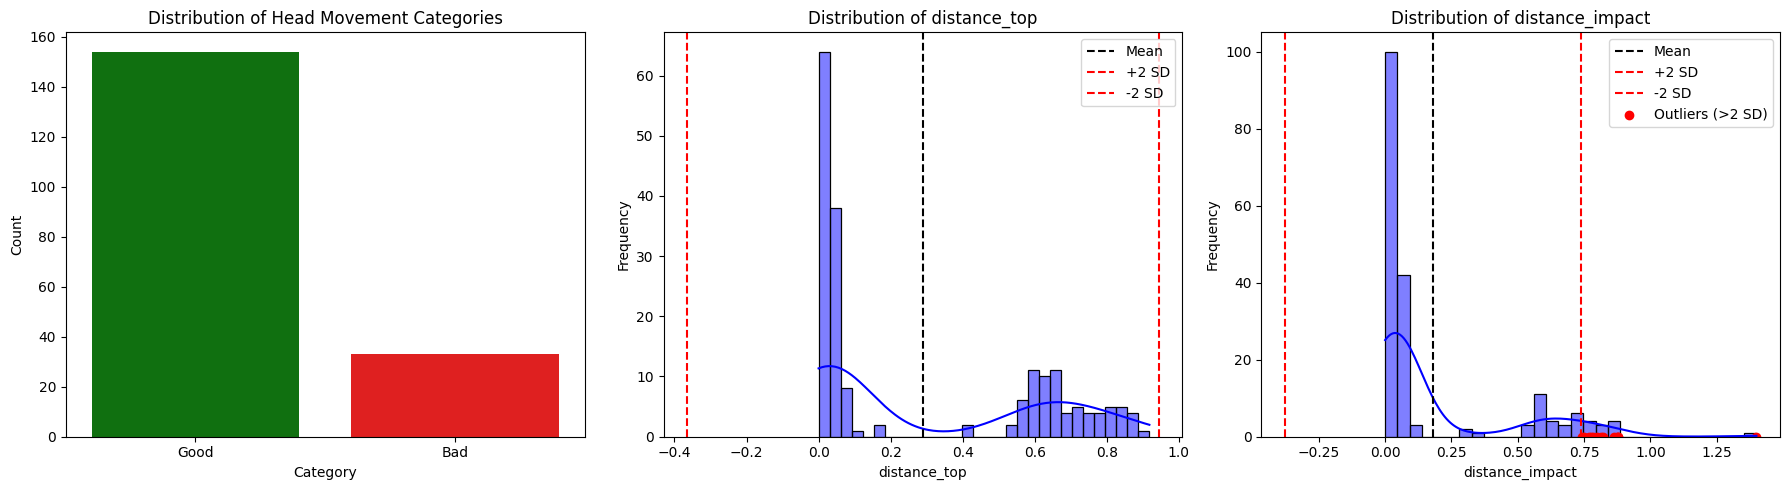

processing iron and down-the-line: 77
Good threshold for Distance Top: 0.6220290660858154
Bad threshold for Distance Top: 0.9499684572219849
Good threshold for Distance Impact: 0.3763868361711502
Bad threshold for Distance Impact: 0.6037053018808365


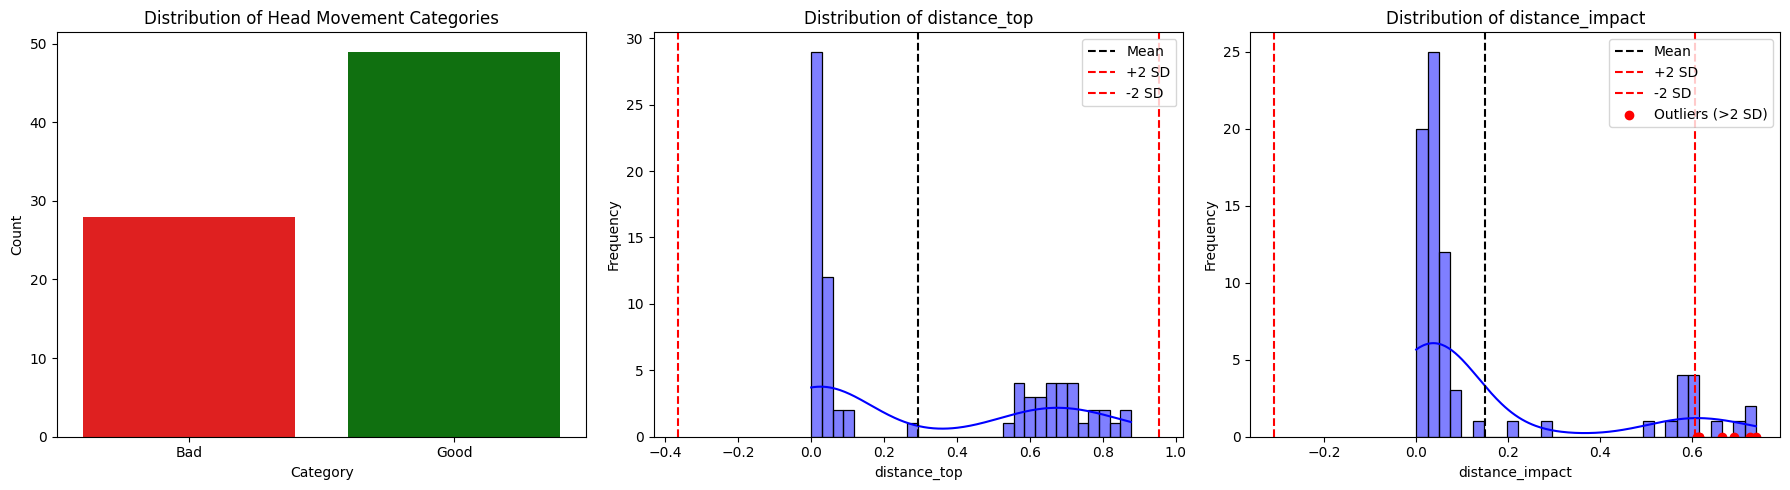

processing iron and face-on: 71
Good threshold for Distance Top: 0.6660793125629425
Bad threshold for Distance Top: 1.0098042488098145
Good threshold for Distance Impact: 0.44268107414245605
Bad threshold for Distance Impact: 0.7133265733718872


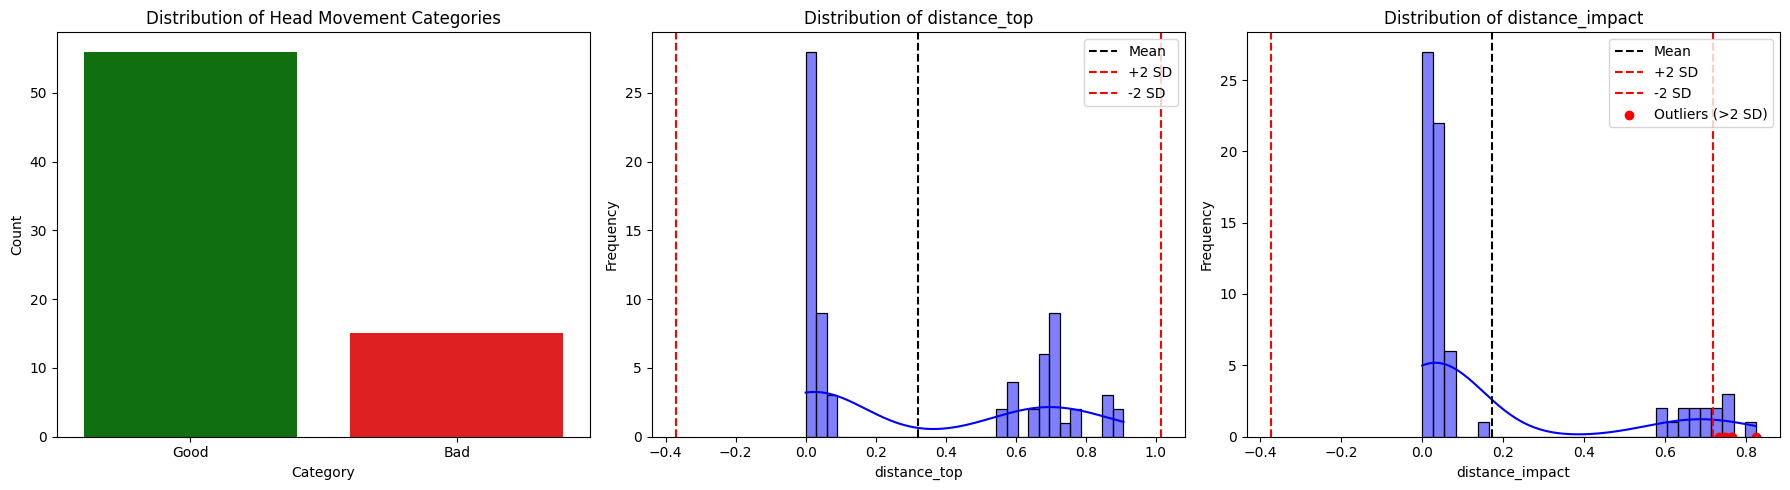

processing iron and other: 81
Good threshold for Distance Top: 0.6813905537128448
Bad threshold for Distance Top: 1.0225994884967804
Good threshold for Distance Impact: 0.40211331844329834
Bad threshold for Distance Impact: 0.6611236333847046


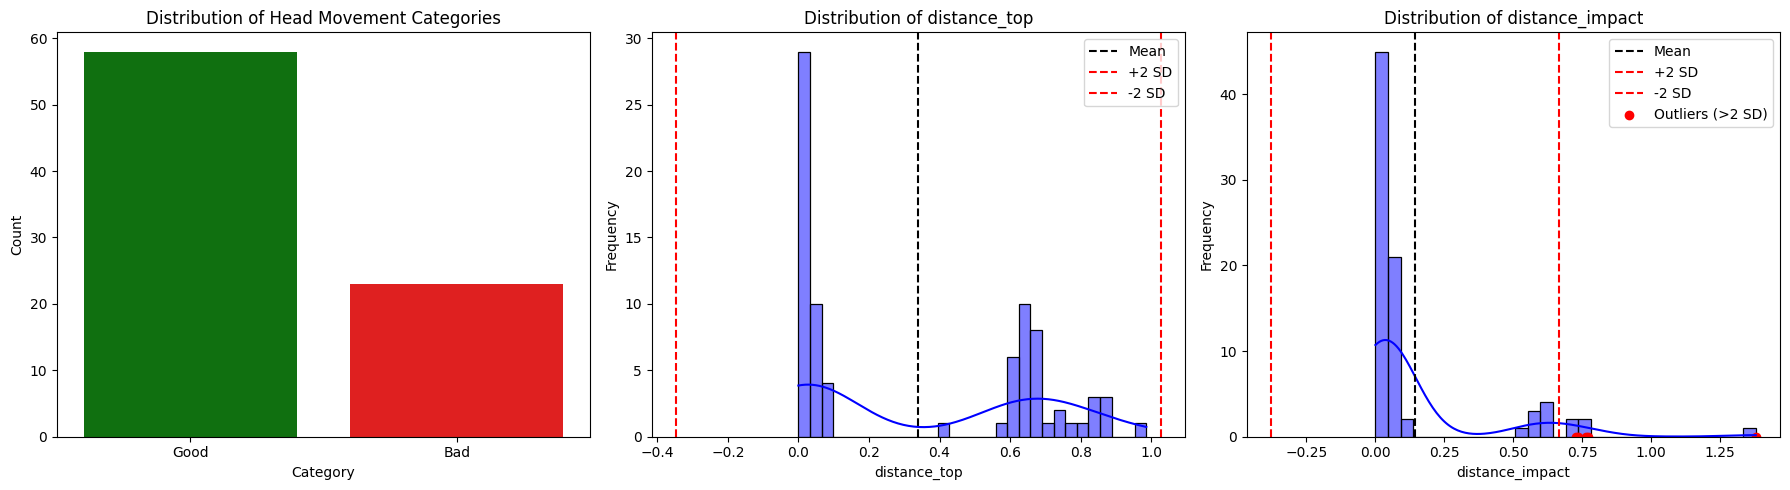

processing fairway club and down-the-line: 0
processing fairway club and face-on: 0
processing fairway club and other: 0
processing wedge and down-the-line: 4
Good threshold for Distance Top: 0.7594189345836639
Bad threshold for Distance Top: 1.1334732174873352
Good threshold for Distance Impact: 0.048603519797325134
Bad threshold for Distance Impact: 0.0666714571416378


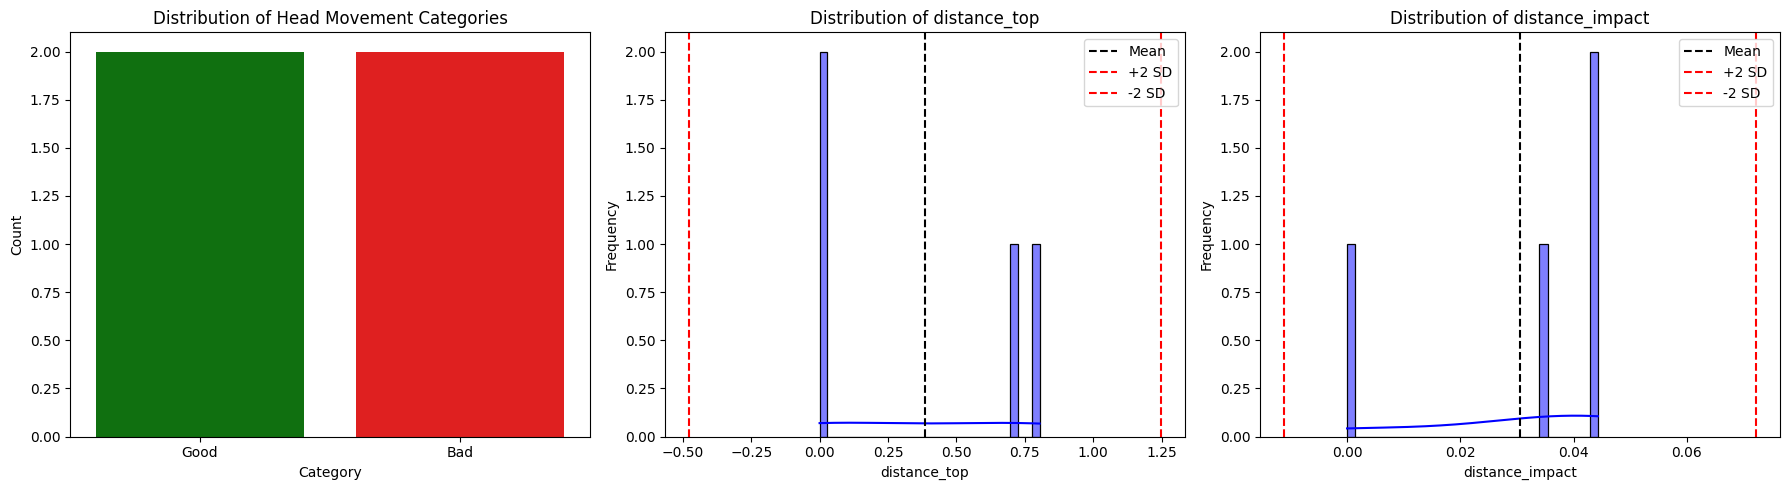

processing wedge and face-on: 11
Good threshold for Distance Top: 0.8101555407047272
Bad threshold for Distance Top: 1.119549810886383
Good threshold for Distance Impact: 0.6790950000286102
Bad threshold for Distance Impact: 0.982760488986969


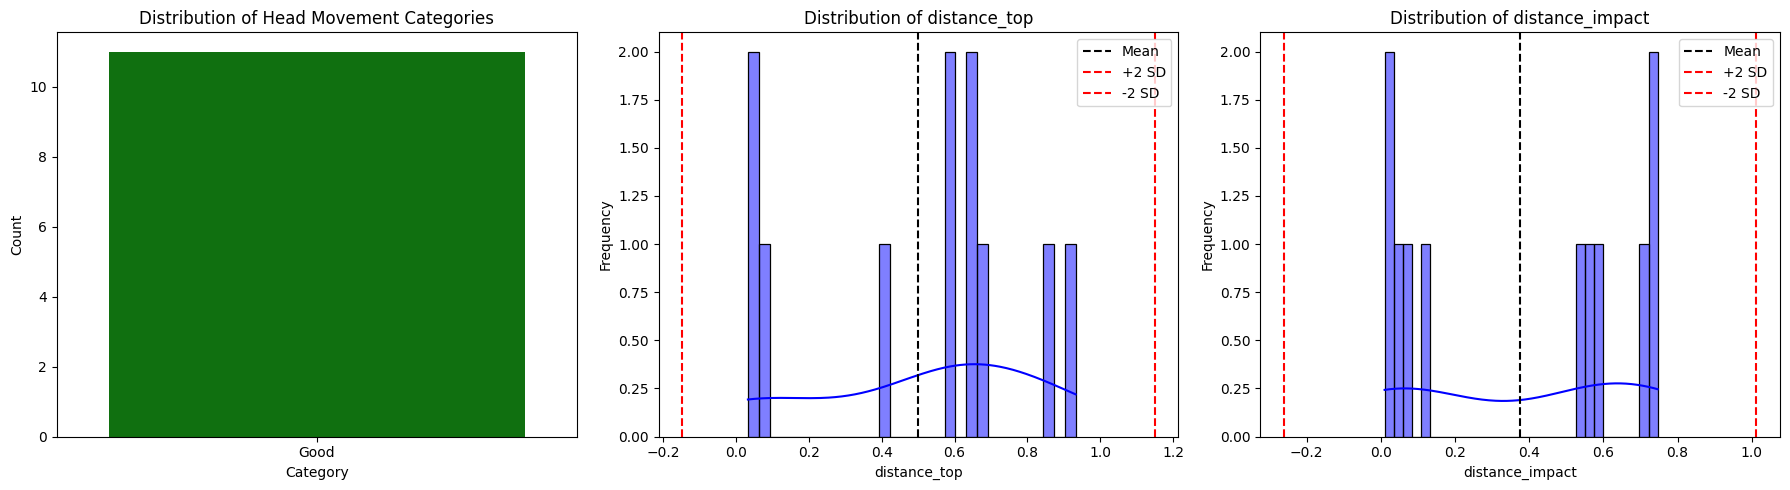

processing wedge and other: 8
Good threshold for Distance Top: 0.7513556182384491
Bad threshold for Distance Top: 1.1165534853935242
Good threshold for Distance Impact: 0.6600483357906342
Bad threshold for Distance Impact: 0.979489654302597


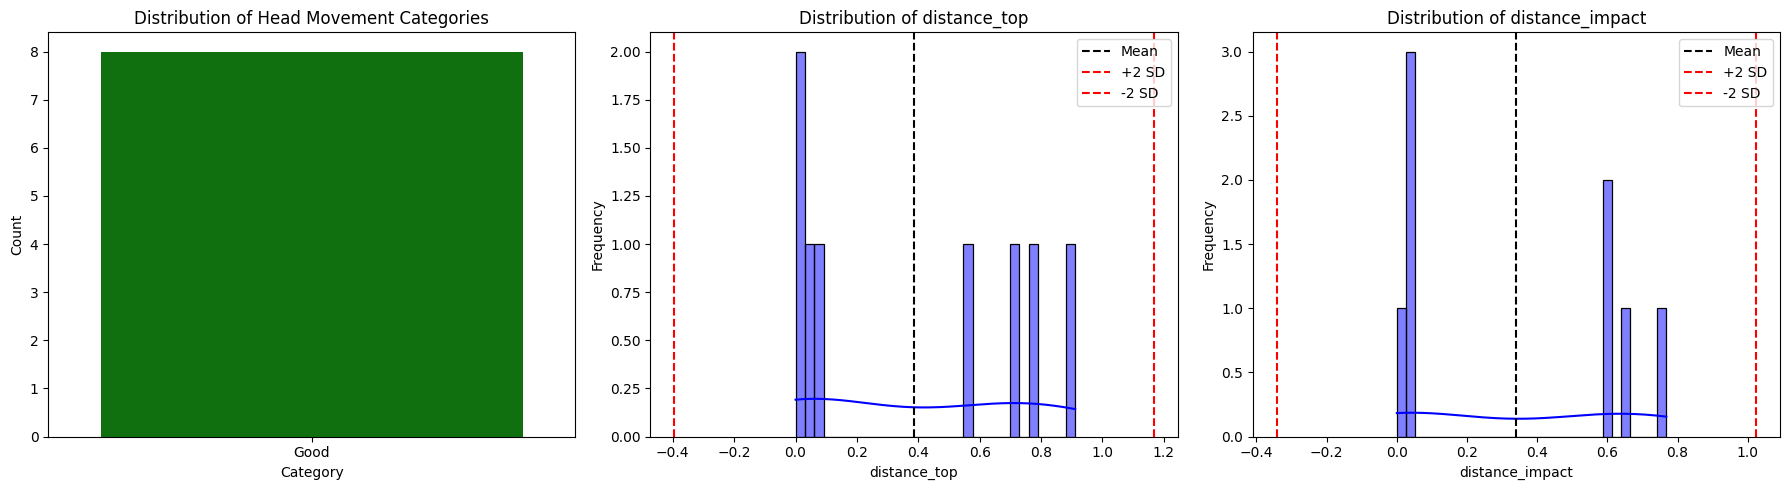

processing hybrid and down-the-line: 17
Good threshold for Distance Top: 0.6411711573600769
Bad threshold for Distance Top: 0.9812709093093872
Good threshold for Distance Impact: 0.36062565445899963
Bad threshold for Distance Impact: 0.580146074295044


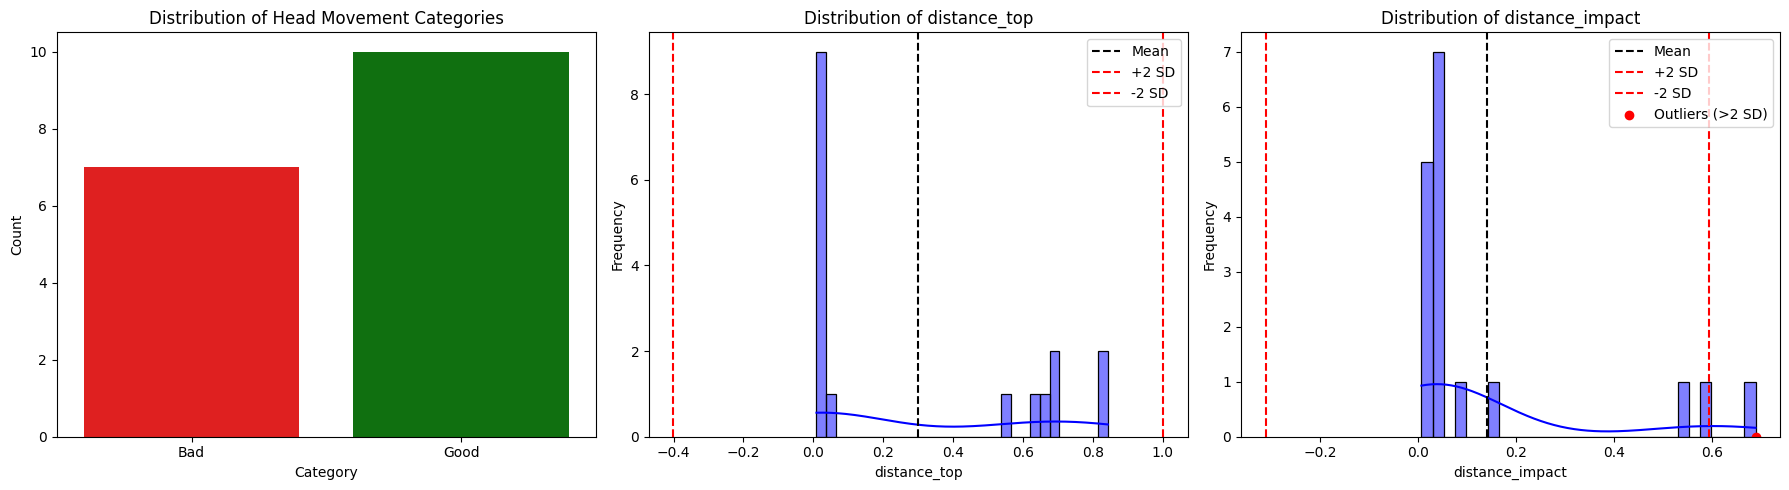

processing hybrid and face-on: 5
Good threshold for Distance Top: 0.3710486739873886
Bad threshold for Distance Top: 0.6115786731243134
Good threshold for Distance Impact: 0.45137032866477966
Bad threshold for Distance Impact: 0.7371530532836914


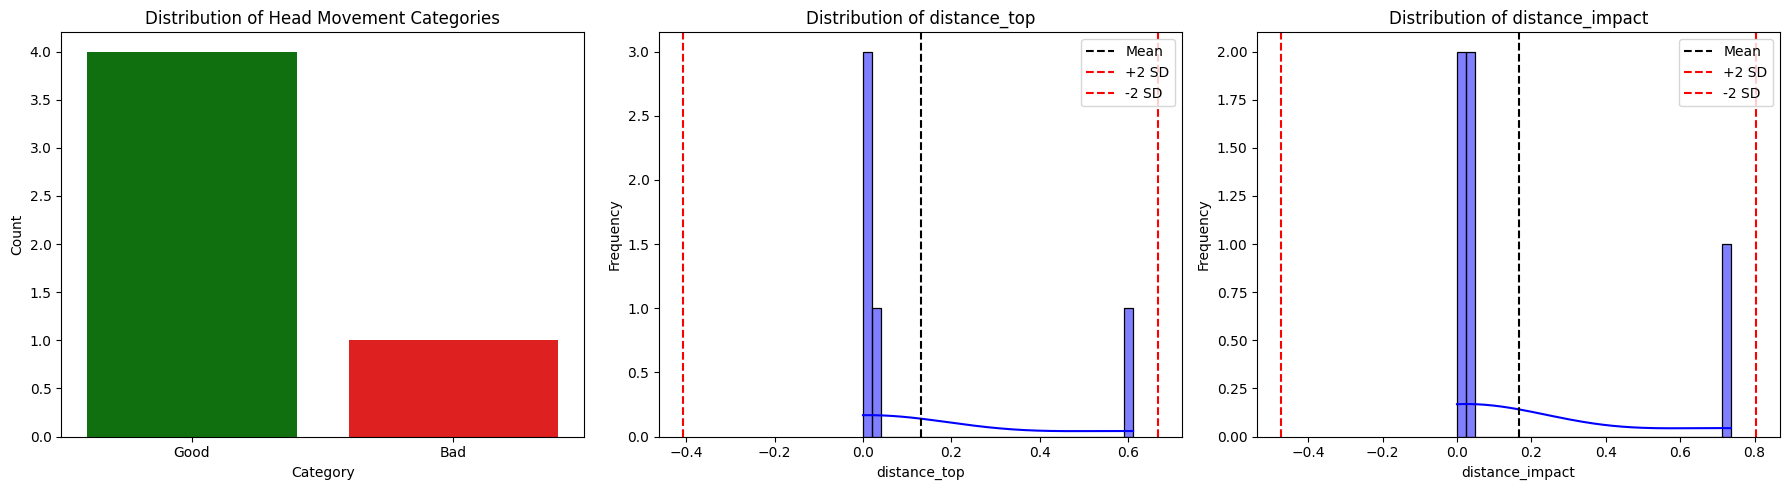

processing hybrid and other: 12
Good threshold for Distance Top: 0.6479479074478149
Bad threshold for Distance Top: 0.9910911917686462
Good threshold for Distance Impact: 0.32926396280527115
Bad threshold for Distance Impact: 0.5350178852677345


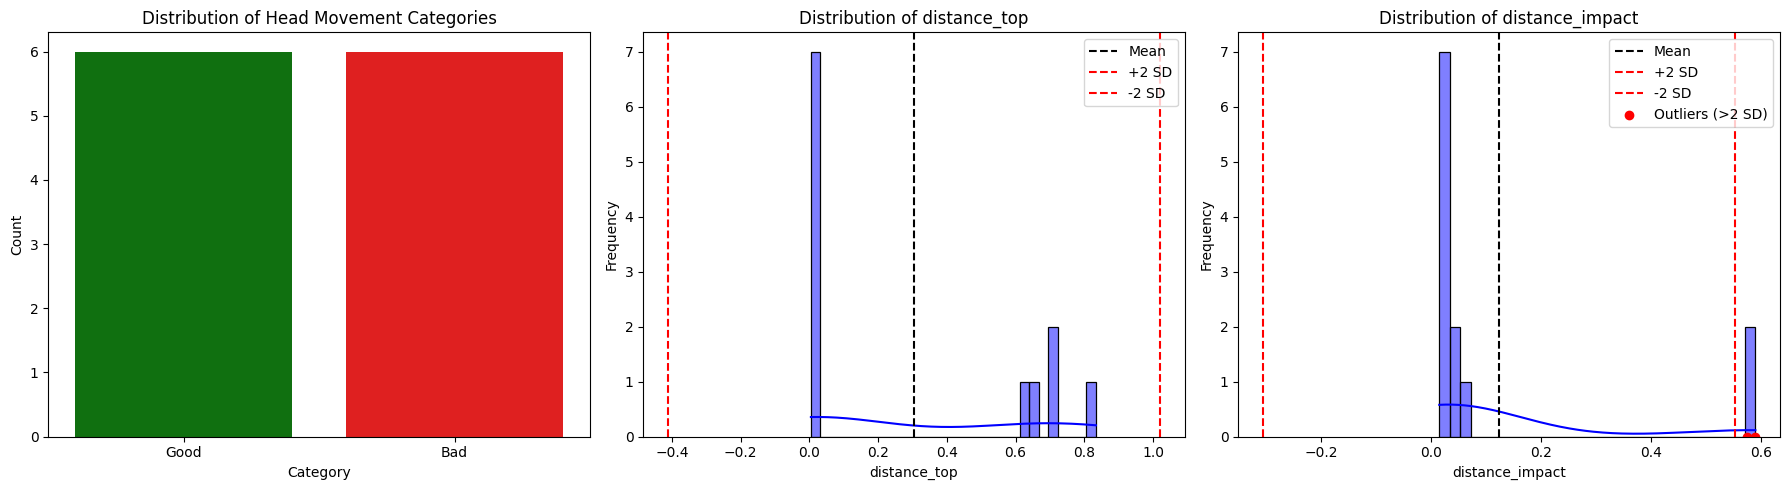

In [75]:
club_types = ["driver" ,"iron", "fairway club", "wedge" ,"hybrid"]
view_types = ["down-the-line", "face-on", "other"]
res_df_list  = []
for club_type in club_types:
    for view_type in view_types:
        temp_df = df[(df["club"] == club_type) & (df["view"] == view_type)]
        print("processing " + club_type + " and " + view_type + ": " + str(len(temp_df)))
        if len(temp_df) > 0:
            id_list = list(temp_df.id)
            ids = []
            for id in id_list:
                ids.append("data/videos_160/" + str(id) + ".mp4")

            pose_results = [all_videos_pose_results[i] for i in id_list]
            
            head_movement_df = calculate_head_movement_metric(pose_results, ids)
            res_df_list.append(head_movement_df)
            create_distribution_plot(head_movement_df)

red_df = pd.concat(res_df_list, ignore_index=True)
red_df.to_csv("1400_video_simple_head_movement_classification.csv",index=False)

## other approaches for the measurements( doing it for all the videos as proof of concept, but can be done for the subsets as well).  

In [81]:
def calculate_spine_angle(shoulder_left, shoulder_right, hip_left, hip_right):
    """
    Calculate the spine angle based on shoulder and hip keypoints.
    """
    shoulder_center = ((shoulder_left[0] + shoulder_right[0]) / 2, (shoulder_left[1] + shoulder_right[1]) / 2)
    hip_center = ((hip_left[0] + hip_right[0]) / 2, (hip_left[1] + hip_right[1]) / 2)
    
    # Calculate the angle between the vertical line and the spine
    delta_x = shoulder_center[0] - hip_center[0]
    delta_y = shoulder_center[1] - hip_center[1]
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    return angle

In [82]:
def calculate_center_hip(left_hip, right_hip):
    """
    Calculate the center hip keypoint as the midpoint between left and right hips.
    """
    center_hip = ((left_hip[0] + right_hip[0]) / 2, (left_hip[1] + right_hip[1]) / 2)
    return center_hip


In [83]:
def analyze_weight_shift(hip_center, foot_left, foot_right):
    """
    Analyze weight shift based on hip and foot positions.
    """
    distance_left = abs(hip_center[0] - foot_left[0])
    distance_right = abs(hip_center[0] - foot_right[0])
    
    if distance_left > distance_right:
        return "Weight on left foot", distance_left, distance_right
    else:
        return "Weight on right foot",distance_left, distance_right

In [84]:
def calculate_knee_angle(hip, knee, ankle):
    """
    Calculate the knee angle based on hip, knee, and ankle keypoints.
    """
    a = np.array(hip)
    b = np.array(knee)
    c = np.array(ankle)
    
    ba = a - b
    bc = c - b

    # Check if either vector is a zero vector
    if np.linalg.norm(ba) == 0 or np.linalg.norm(bc) == 0:
        return np.nan  # Return NaN for invalid cases
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))

    # Handle potential numerical issues (e.g., cosine_angle slightly outside [-1, 1])
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    
    angle = np.degrees(np.arccos(cosine_angle))
    
    return angle


In [85]:
def classify_stance_improved(head_positions, spine_angles, weight_shift, right_knee_angles, left_knee_angles):
    """
    Classify stance as "good" or "bad" using multiple features.
    """
    # Rule-based classification (can be replaced with a machine learning model)
    head_movement_good = all(calculate_distance(head_positions["Address"], pos) < THRESHOLD for pos in [head_positions["Top"], head_positions["Impact"]])
    spine_angle_good = all(abs(angle - spine_angles["Address"]) < 5 for angle in [spine_angles["Top"], spine_angles["Impact"]])
    weight_shift_good = weight_shift["Top"] == "Weight on right foot" and weight_shift["Impact"] == "Weight on left foot"
    right_knee_angle_good = all(20 <= angle <= 30 for angle in [right_knee_angles["Address"], right_knee_angles["Top"], right_knee_angles["Impact"]])
    left_knee_angle_good = all(20 <= angle <= 30 for angle in [left_knee_angles["Address"], left_knee_angles["Top"], left_knee_angles["Impact"]])

    return head_movement_good, spine_angle_good, weight_shift_good, right_knee_angle_good, left_knee_angle_good


In [88]:
# Initialize head positions dictionary
head_positions = {}
spine_angles = {}
weight_shifts = {}
left_knee_angles = {}
right_knee_angles = {}


i = 0
res_values = []
for result in all_videos_pose_results:
    for event_id in [0,3,5]:
        keypoints = result[event_id].keypoints.xyn.cpu().numpy()[0]
        head_position = extract_head_position(keypoints)
        shoulder_left_positions = keypoints[GetKeypoint.LEFT_SHOULDER.value]
        shoulder_right_positions = keypoints[GetKeypoint.RIGHT_SHOULDER.value]
        hip_left_positions = keypoints[GetKeypoint.LEFT_HIP.value]
        hip_right_positions = keypoints[GetKeypoint.RIGHT_HIP.value]
        knee_right_positions = keypoints[GetKeypoint.RIGHT_KNEE.value]
        knee_left_positions = keypoints[GetKeypoint.LEFT_KNEE.value]
        ankle_left_positions = keypoints[GetKeypoint.LEFT_ANKLE.value]
        ankle_right_positions = keypoints[GetKeypoint.RIGHT_ANKLE.value]
        
        hip_center_positions = calculate_center_hip(hip_left_positions,hip_right_positions)
        foot_left_positions = ankle_left_positions
        foot_right_positions = ankle_right_positions
    
        # Calculate spine angle
        spine_angle = calculate_spine_angle(shoulder_left_positions, shoulder_right_positions, hip_left_positions, hip_right_positions)
        # Analyze weight shift
        weight_shift = analyze_weight_shift(hip_center_positions, foot_left_positions, foot_right_positions)
        # Calculate knee angles
        left_knee_angle = calculate_knee_angle(hip_left_positions, knee_left_positions, ankle_left_positions)
        right_knee_angle = calculate_knee_angle(hip_right_positions, knee_right_positions, ankle_right_positions)

        head_positions[event_names[event_id]] = head_position
        spine_angles[event_names[event_id]] = spine_angle  
        weight_shifts[event_names[event_id]] = weight_shift
        left_knee_angles[event_names[event_id]] = left_knee_angle
        right_knee_angles[event_names[event_id]] = right_knee_angle
    head_movement_good, spine_angle_good, weight_shift_good, right_knee_angle_good, left_knee_angle_good = classify_stance_improved(head_positions, spine_angles, weight_shifts, right_knee_angles, left_knee_angles)
    res_values.append({'video_path': 'data/videos_160/' + str(i) + '.mp4', 'head movement': head_movement_good, 'spine angle' : spine_angle_good, 'weight shift': weight_shift_good, 'right knee angle' : right_knee_angle_good, 'left knee angle': left_knee_angle_good})
    i = i + 1

In [89]:
## write results in csv
# Convert list of dictionaries to DataFrame  
df = pd.DataFrame(res_values)  

# Write to CSV  
df.to_csv("1400_video_all_metrices_classification.csv", index=False) 